In [2]:
import numpy as np
import matplotlib.pyplot as plt


from collections import Counter


import random

In [3]:
def prime(sequence):
    inverse_composite=sequence[::-1]
    for i in range(len(inverse_composite)):
        if inverse_composite[i]=='6':
            inverse_composite[i]='9'
        elif inverse_composite[i]=='9':
            inverse_composite[i]='6'
        elif inverse_composite[i].islower():
            inverse_composite[i]=inverse_composite[i].upper()
        elif inverse_composite[i].isupper():
            inverse_composite[i]=inverse_composite[i].lower()
        else:
            raise SyntaxError
    return inverse_composite

def detect_forward_sites(DNA,site):
    site_length = len(site)
    start_positions = []
    end_positions = []
    
    # Slide through the DNA looking for matches
    for i in range(len(DNA) - site_length + 1):
        # Check if current window matches the site
        if DNA[i:i+site_length] == site:
            start_positions.append(i)#computer positions
    
    return start_positions

def detect_backward_sites(DNA,site):
    site_length = len(site)
    start_positions = []
    end_positions = []
    
    # Slide through the DNA looking for matches
    for i in range(len(DNA) - site_length + 1):
        # Check if current window matches the site
        if DNA[i:i+site_length] == site[::-1]:
            start_positions.append(i)#computer positions
    
    return start_positions

#ALL positions recorded in natural counting, not computer indices, delete and inverts [site_1,site_2] inclusive
def delete_between(DNA,site_1,site_2):
    return DNA[:site_1-1]+DNA[site_2:]  

def invert_between(DNA,site_1,site_2):
    return DNA[:site_1-1]+prime(DNA[site_1-1:site_2])+DNA[site_2:] 


        

    

In [4]:
def evaluate_colour_CRE(DNA,choice1,choice2):

    num1, direction_1 = choice1
    num2, direction_2 = choice2
    #WLOG,make num 1 the smaller one
    if num1 > num2:
        num1, num2 = num2, num1
        direction_1, direction_2 = direction_2, direction_1
    
    # Determine which function to use
    if direction_1 == 'forward':
        if direction_1 == direction_2:
            return delete_between(DNA,num1+1,num2)
        elif direction_1!=direction_2:
            return invert_between(DNA,num1+1,num2+1)
    elif direction_1=='backward':
        if direction_1 == direction_2:
            return delete_between(DNA,num1+1,num2)
        else :
            return 'DoNotCount'

In [5]:
initial_dna_sequence = "A9B6C9D6EF6G9H6I9J6K"
numberofevents = 20
DNA = initial_dna_sequence

# outcome_lists= probability_calculation(initial_dna_sequence)
def probability_calculation_polylox(DNA,numberofevents):
    outcome_list=[]

    for _ in range(numberofevents):
        outcome_list.append(Counter())
    recombinases_event=  0

    outcome_list[0][DNA] = 1

    # Stage 1
    for whichstage in range(1,numberofevents):
        stage = outcome_list[whichstage-1]
        for dna,probs in stage.items():
            # Now work out all the things the recombinases can do
            forward_9_positions=detect_forward_sites(list(dna),['9'])
            backward_6_positions=detect_backward_sites(list(dna),['6'])
            combined = [(num, 'forward') for num in forward_9_positions] + [(num, 'backward') for num in backward_6_positions]
            recombinase_acted = 0
            thisinput = Counter()
            for i in range(len(combined)):
                for j in range(i+1,len(combined)):
                    choice1,choice2 = combined[i], combined[j]
                    
                    output = evaluate_colour_CRE(list(dna),choice1,choice2)

                    if output!='DoNotCount':
                        recombinase_acted += 1
                        formatted_output = "".join(output)

                        #print(f"stage {whichstage} dna {dna} recombinase {recombinase_acted} output: {formatted_output}")  # !!!Remove before flight

                        thisinput[formatted_output] +=1

            if recombinase_acted==0:
                normfactor = 1
                thisinput[dna] = 1
            else:
                normfactor = recombinase_acted
            
            for key in thisinput:
                outcome_list[whichstage][key] += thisinput[key]*probs/normfactor
    return outcome_list

In [6]:
# Visualisation function to plot ranked probability distributions after each recombination event
def plot_ranked_probabilities(outcome_list):
    num_stages = len(outcome_list)
    fig, axes = plt.subplots(num_stages, 3, figsize=(18, 4 * num_stages), squeeze=False)

    for stage in range(num_stages):
        probs = np.array(sorted(outcome_list[stage].values(), reverse=True))
        ranks = np.arange(1, len(probs) + 1)

        # Linear scale
        axes[stage, 0].plot(ranks, probs, marker='o', linestyle='-', color='r')
        axes[stage, 0].set_xlabel('Rank')
        axes[stage, 0].set_ylabel('Probability')
        axes[stage, 0].set_yscale('linear')


        # Log-y scale
        axes[stage, 1].plot(ranks, probs, marker='o', linestyle='-', color='g')
        axes[stage, 1].set_xlabel('Rank')
        axes[stage, 1].set_ylabel('Probability (Log Scale)')
        axes[stage, 1].set_yscale('log')


        # Log-log scale
        axes[stage, 2].plot(ranks, probs, marker='o', linestyle='-', color='b')
        axes[stage, 2].set_xlabel('Rank (Log Scale)')
        axes[stage, 2].set_ylabel('Probability (Log Scale)')
        axes[stage, 2].set_yscale('log')
        axes[stage, 2].set_xscale('log')


        # Optional: add row labels for stages
        axes[stage, 0].set_ylabel(f'Probability\n(Stage {stage})')

    plt.tight_layout()
    plt.show()

In [7]:
# Visualisation function to plot the probabilities sum and entropy of outcomes at each stage
def plot_probabilities(outcome_list, numberofevents=5,rank=0):    
    probsum = 0
    num_of_possible_outcomes = np.zeros(numberofevents)
    total_num_of_outcomes = np.zeros(numberofevents)
    entropy = np.zeros(numberofevents)
    initial_dict=Counter()
    for stage in range(numberofevents):
        probsum = np.sum(list(outcome_list[stage].values()))
        if (probsum-1)> 0.01 or (probsum-1)<-0.01:
            raise ValueError(f"Stage {stage} does not sum to 1, it sums to {probsum}. Please check the input data or the calculation logic.")
        entropy[stage] = -np.sum([p * np.log2(p) for p in outcome_list[stage].values() if p > 0])
        num_of_possible_outcomes[stage] = len(outcome_list[stage])
        initial_dict.update(outcome_list[stage])
        total_num_of_outcomes[stage] = len(initial_dict)

    # # Plot normalisation
    # plt.figure(figsize=(6, 3))
    # plt.plot(probsum, marker='o', linestyle='-', color='k')
    # plt.xlabel('Stage')
    # plt.ylabel('Sum of Probabilities')
    # #plt.ylim(0, 1.1)

    # Plot number of possible outcomes
    plt.figure(figsize=(6, 3))
    plt.plot(num_of_possible_outcomes, marker='o', linestyle='-', color='k')
    plt.xlabel('Stage')
    plt.ylabel('Number of Possible Outcomes occuring at Each Stage')
    #plt.ylim(0, np.max(num_of_possible_outcomes) * 1.1)

    # Plot cumulative number of possible outcomes
    plt.figure(figsize=(6, 3))
    plt.plot(total_num_of_outcomes, marker='o', linestyle='-', color='k')
    plt.xlabel('Stage')
    plt.ylabel('Cumulative number of Possible Outcomes at Each Stage')
    #plt.ylim(0, np.max(num_of_possible_outcomes) * 1.1)

    # Plot entropy
    plt.figure(figsize=(6, 3))
    plt.plot(entropy, marker='o', linestyle='-', color='k')
    plt.xlabel('Stage')
    plt.ylabel('Entropy')
    #plt.ylim(0, np.max(entropy) * 1.1)

    # Plot ranked probabilities
    plot_ranked_probabilities(outcome_list) if rank==1 else None

    plt.show()



    


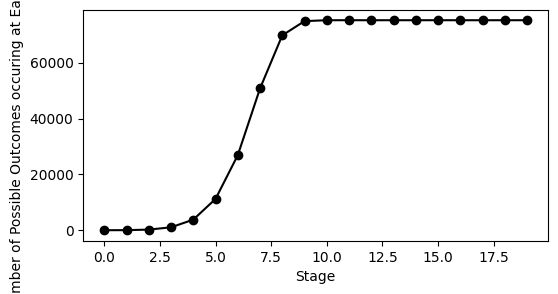

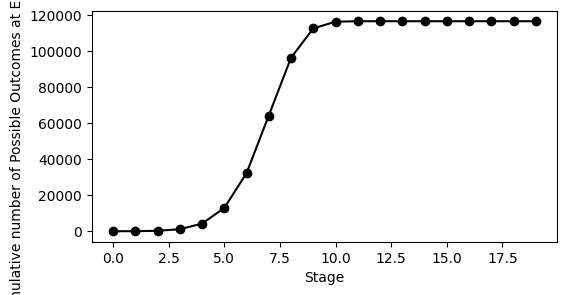

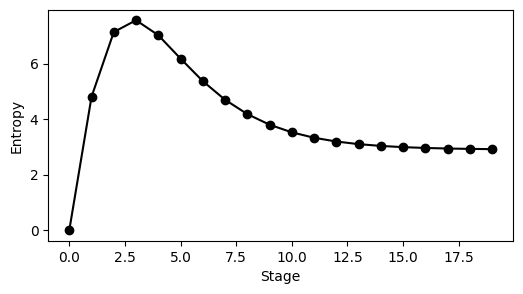

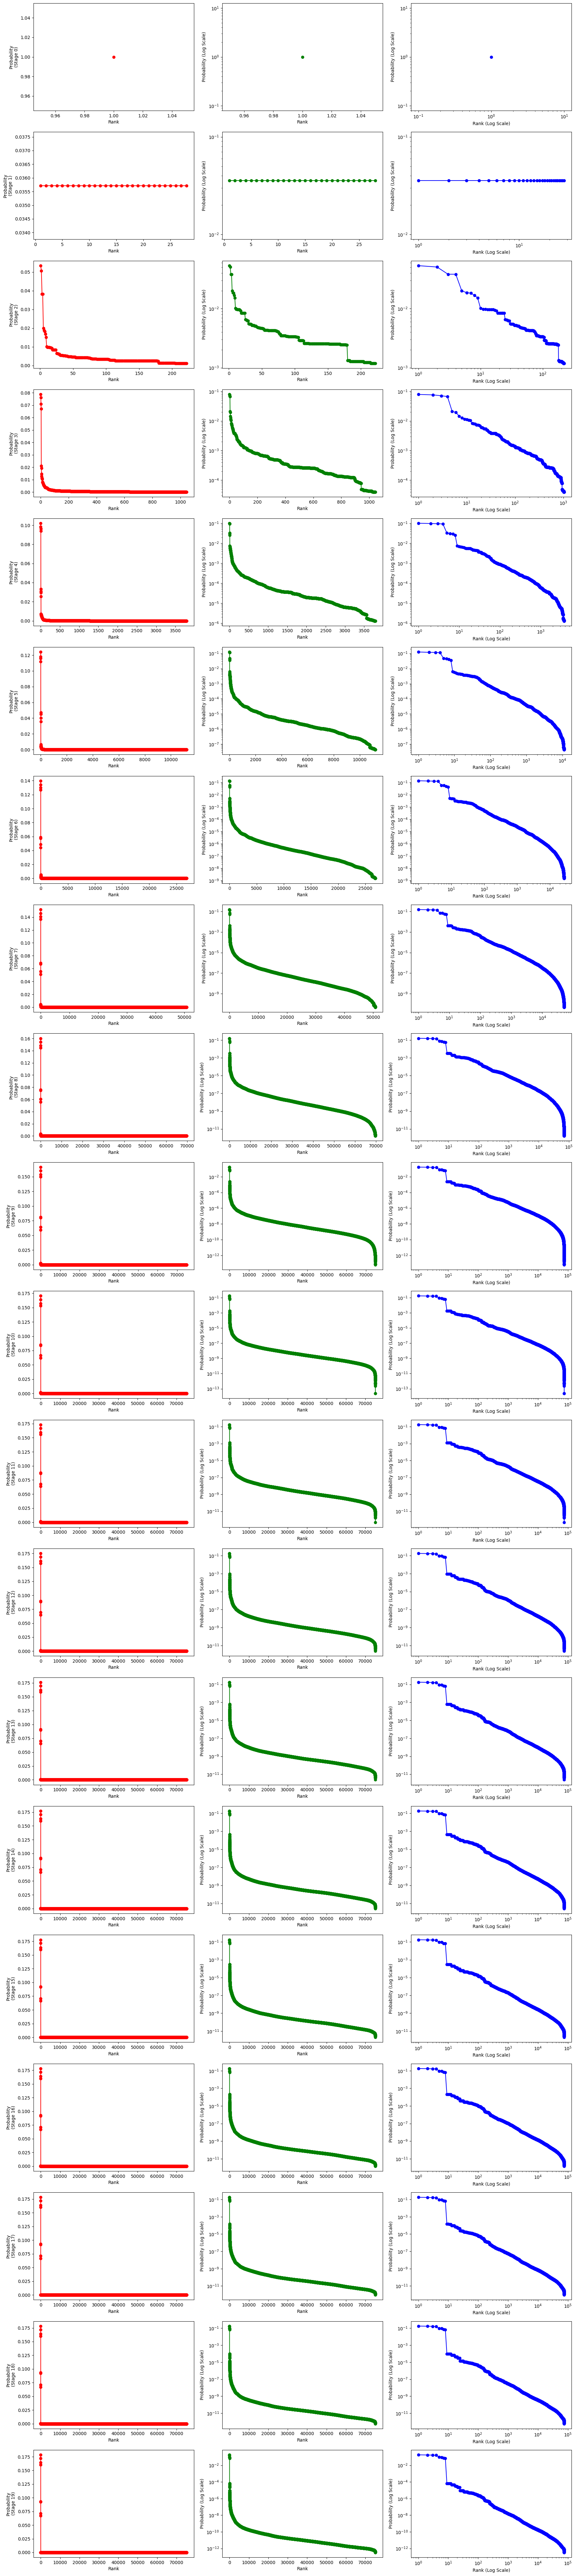

In [8]:
outcome_list = probability_calculation_polylox(DNA, numberofevents)
plot_probabilities(outcome_list, numberofevents=numberofevents,rank=1)

In [9]:
topbcds=np.argsort(list(outcome_list[-1].values()))[::-1][:8]
topbcds
outcome_list[-1].most_common(10)

[('A9B6K', 0.17846767944471267),
 ('A9b6K', 0.17206834136718804),
 ('A9J6K', 0.16415601154071907),
 ('A9j6K', 0.1602050948712195),
 ('A9d6K', 0.09334888838710804),
 ('A9D6K', 0.09232355342979078),
 ('A9h6K', 0.0713212974168582),
 ('A9H6K', 0.06689890827795175),
 ('A9fe9d6K', 6.579820054252814e-05),
 ('A9d6EF6K', 6.57971067459525e-05)]

In [10]:
#Just to get some numbers, ignore this part
probsum = 0
num_of_possible_outcomes = np.zeros(numberofevents)
total_num_of_outcomes = np.zeros(numberofevents)
entropy = np.zeros(numberofevents)
initial_dict=Counter()
for stage in range(numberofevents):
    probsum = np.sum(list(outcome_list[stage].values()))
    if (probsum-1)> 0.01 or (probsum-1)<-0.01:
        raise ValueError(f"Stage {stage} does not sum to 1, it sums to {probsum}. Please check the input data or the calculation logic.")
    entropy[stage] = -np.sum([p * np.log2(p) for p in outcome_list[stage].values() if p > 0])
    num_of_possible_outcomes[stage] = len(outcome_list[stage])
    initial_dict.update(outcome_list[stage])
    total_num_of_outcomes[stage] = len(initial_dict)



In [11]:
entropy

array([-0.        ,  4.80735492,  7.13878204,  7.565839  ,  7.0263159 ,
        6.18414918,  5.37201955,  4.70074178,  4.18430878,  3.80247137,
        3.52720784,  3.33228406,  3.19609691,  3.101946  ,  3.03740529,
        2.993466  ,  2.96371968,  2.9436736 ,  2.93021418,  2.92120355])

In [12]:
total_num_of_outcomes

array([1.00000e+00, 2.90000e+01, 2.35000e+02, 1.13200e+03, 4.22700e+03,
       1.29230e+04, 3.22570e+04, 6.42830e+04, 9.63750e+04, 1.12680e+05,
       1.16404e+05, 1.16660e+05, 1.16664e+05, 1.16664e+05, 1.16664e+05,
       1.16664e+05, 1.16664e+05, 1.16664e+05, 1.16664e+05, 1.16664e+05])

In [13]:
total_num_of_outcomes[-1]==1866868

np.False_

In [14]:
# import pickle
# with open('my_variable.pkl', 'wb') as f:
#     pickle.dump(outcome_list, f)

In [15]:
def run_probability_calculation_and_plot_polylox(DNA_sequence, numberofevents=numberofevents,rank=0,plot=0):
    outcome_list = probability_calculation_polylox(DNA_sequence, numberofevents)
    plot_probabilities(outcome_list, numberofevents,rank=rank) if plot==1 else None
    return outcome_list

Calculating for Polylox sequence 1
Calculating for Polylox sequence 2
Calculating for Polylox sequence 3
Calculating for Polylox sequence 4
Calculating for Polylox sequence 5


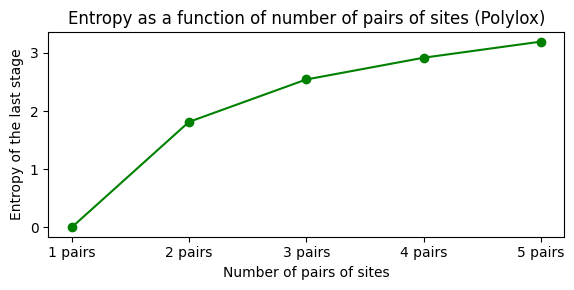

In [18]:
polylox_sequence_1pair = "A9B6C"
polylox_sequence_2pair = "A9B6C9D6E"
polylox_sequence_3pair = "A9B6C9D6E9F6G"
polylox_sequence_4pair = "A9B6C9D6E9F6G9H6I"
polylox_sequence_5pair = "A9B6C9D6E9F6G9H6I9J6K"
polylox_sequence_6pair = "A9B6C9D6E9F6G9H6I9J6K9L6M"
polylox_sequence_7pair = "A9B6C9D6E9F6G9H6I9J6K9L6M9N6O"
polylox_sequence_8pair = "A9B6C9D6E9F6G9H6I9J6K9L6M9N6O9P6Q"
polylox_sequence_9pair = "A9B6C9D6E9F6G9H6I9J6K9L6M9N6O9P6Q9R6S"
polylox_sequence_10pair = "A9B6C9D6E9F6G9H6I9J6K9L6M9N6O9P6Q9R6S9T6U"
polylox_lists = [
    polylox_sequence_1pair,
    polylox_sequence_2pair,
    polylox_sequence_3pair,
    polylox_sequence_4pair,
    polylox_sequence_5pair,
    # polylox_sequence_6pair,
    # polylox_sequence_7pair,
    # polylox_sequence_8pair,
    # polylox_sequence_9pair,
    # polylox_sequence_10pair
]
entropy = np.zeros(len(polylox_lists))
for i in range(len(polylox_lists)):#len(polylox_lists)):
    print(f"Calculating for Polylox sequence {i+1}")
    DNA_sequence_polylox = polylox_lists[i]
    outcome_list_polylox = run_probability_calculation_and_plot_polylox(DNA_sequence_polylox, plot=0)
    entropy[i] = -np.sum([p * np.log2(p) for p in outcome_list_polylox[-2].values() if p > 0])

# Plot the entropy of Polylox sequences
plt.figure(figsize=(6, 3))
plt.plot(entropy, marker='o', linestyle='-', color='g')
plt.xticks(range(len(polylox_lists)), [f'{i+1} pairs' for i in range(len(polylox_lists))])
plt.xlabel('Number of pairs of sites')
plt.ylabel('Entropy of the last stage')
plt.title('Entropy as a function of number of pairs of sites (Polylox)')
plt.tight_layout()
plt.show()